<a href="https://colab.research.google.com/github/QuinnWass/CPSC-4310-01/blob/master/FakeNewsPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preproccessing for Fake News Classifier

In [0]:
!pip install twython

In [57]:
#Imports
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from collections import Counter
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from tqdm   import tqdm, tqdm_gui, tqdm_notebook
from IPython.utils import io

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
fake_cb_dataset = 'https://raw.githubusercontent.com/QuinnWass/CPSC-4310-01/master/FakeNewsClassifier/rawdata/fake-CB.csv'
fake_cb_df = pd.read_csv(fake_cb_dataset)
fake_cb_df['classification'] = "fake"

real_cb_dataset = 'https://raw.githubusercontent.com/QuinnWass/CPSC-4310-01/master/FakeNewsClassifier/rawdata/true-CB.csv'
real_cb_df = pd.read_csv(real_cb_dataset)
real_cb_df['classification'] = "real"

## Inspection of Fake News & Real News datasets by Clément Bisaillon


In [0]:
def printDataFrameDetails(df):
  print("Head of data", df.head())
  print("Tail of data", df.tail())
  print("Column names:", df.columns)
  print("Shape of dataset:",df.shape)
  print("Decription of dataset:",df.describe())

In [0]:
printDataFrameDetails(fake_cb_df)
printDataFrameDetails(real_cb_df)

In [0]:
def cleanWordList(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(i) for i in re.sub("[^a-zA-Z]", " ", text).split() if i not in stopwords.words("english")]).lower()
  
def getSentiment(text):
  sid = SentimentIntensityAnalyzer()
  return sid.polarity_scores(text)['compound']


In [0]:
def preproccessDataFrame(df):
  df['parsed_text'] = df['text'].apply(cleanWordList)
  df['parsed_title'] = df['title'].apply(cleanWordList)

  # We should also drop the original columns
  df = df.drop(columns=['title', 'text'])

  df['sentiment'] = df['parsed_text'].apply(getSentiment)
  df['title_sentiment'] = df['parsed_title'].apply(getSentiment)
  df['word_count'] = df['parsed_text'].apply(lambda x: len(x.split()))
  df['title_word_count'] = df['parsed_title'].apply(lambda x: len(x.split()))

In [0]:
#Parses parts of speech in parsed_text column and applies their counts to new
#columns in the dataframe

#The operations in this cell will take approximately 15 minutes.
#We have provided pre-parsed datasets to avoid having to run preprocessing
#for the dataset.

%%capture 
#^^for suppressing output

merged_df = fake_cb_df.append(real_cb_df)

#process parts of speech using NLTK and add their counts to the df

parts_of_speech = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ',
                    'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP',
                    'NNPS', 'PDT', 'PRP$', 'RB', 'RBR', 'PRP', 'RBS',
                    'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP',
                    'VBZ', 'WDT', 'WP', 'WP$', 'WRB' ]


#Remove problematic entries and reset the indices
merged_df = merged_df.dropna()
merged_df = df.reset_index(drop=True)


#This tokenizes all the words in the articles
tokenized = pd.DataFrame(merged_df['parsed_text'].apply(nltk.word_tokenize))

#Create new columns to apply counts
for pos in parts_of_speech:
  tokenized[pos] = 0


#Loop through all elements of the dataset and get counts of each part of speech
#.. add them to tokenized dataframe.
with tqdm_notebook(total=tokenized.shape[0]) as pbar:
  for index, row in tokenized.iterrows():
      counts = Counter(x[1] for x in nltk.pos_tag(row['parsed_text']))
      for pos in parts_of_speech:
        tokenized[pos][index] = counts[pos]
      pbar.update(1)



#Merged tokenized's parts of speech section with the main merged dataframe
testok = tokenized.drop('parsed_text', axis = 1)
tester = merged_df
result_df = pd.concat([tester, testok], axis=1, sort=False)

In [0]:
tokenized.head()

In [0]:
tokenized.tail()

In [0]:
result_df.tail()

In [0]:
# Uncomment to run parsing. This will take a while. Parsed files are on our github
#preproccessDataFrame(fake_cb_df)
#preproccessDataFrame(real_cb_df)

# Visualization

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

#Load preproccessed data
fake_cb_dataset = 'https://raw.githubusercontent.com/QuinnWass/CPSC-4310-01/master/FakeNewsClassifier/processeddata/fake_cb_preproc.csv'
fake_cb_df = pd.read_csv(fake_cb_dataset)
real_cb_dataset = 'https://raw.githubusercontent.com/QuinnWass/CPSC-4310-01/master/FakeNewsClassifier/processeddata/real_cb_preproc.csv'
real_cb_df = pd.read_csv(real_cb_dataset)
merged_cb_dataset = 'https://raw.githubusercontent.com/QuinnWass/CPSC-4310-01/master/FakeNewsClassifier/processeddata/cb_full_parsed.csv'
merged_cb_df = pd.read_csv(merged_cb_dataset)

In [0]:
fake_cb_df['classification'] = 'fake'
real_cb_df['classification'] = 'real'
fake_cb_df = fake_cb_df.drop(columns=['Unnamed: 0'])
real_cb_df = real_cb_df.drop(columns=['Unnamed: 0'])
real_cb_df = real_cb_df.drop(columns=['Unnamed: 0.1'])

In [61]:
real_cb_df.head()

,subject,date,parsed_text,parsed_title,sentiment,title_sentiment,word_count,title_word_count,classification
0,politicsNews,"December 31, 2017",washington reuters the head conservative repub...,as u s budget fight loom republicans flip fisc...,0.9776,-0.5423,464,10,real
1,politicsNews,"December 29, 2017",washington reuters transgender people allowed ...,u s military accept transgender recruit monday...,0.8473,0.3818,399,8,real
2,politicsNews,"December 31, 2017",washington reuters the special counsel investi...,senior u s republican senator let mr mueller job,-0.5859,0.0000,276,9,real
3,politicsNews,"December 30, 2017",washington reuters trump campaign adviser geor...,fbi russia probe helped australian diplomat ti...,0.3415,0.0000,239,8,real
4,politicsNews,"December 29, 2017",seattle washington reuters president donald tr...,trump want postal service charge much amazon s...,0.8658,0.2500,520,8,real


In [62]:
fake_cb_df.head()

,subject,date,parsed_text,parsed_title,sentiment,word_count,title_word_count,title_sentiment,classification
0,News,"December 31, 2017",donald trump wish americans happy new year lea...,donald trump sends out embarrassing new year e...,0.9661,289,11,-0.7561,fake
1,News,"December 31, 2017",house intelligence committee chairman devin nu...,drunk bragging trump staffer started russian c...,-0.3672,194,8,-0.3400,fake
2,News,"December 30, 2017",on friday revealed former milwaukee sheriff da...,sheriff david clarke becomes an internet joke ...,-0.9929,378,15,-0.2960,fake
3,News,"December 29, 2017",on christmas day donald trump announced would ...,trump is so obsessed he even has obama name co...,0.4430,296,14,-0.3052,fake
4,News,"December 25, 2017",pope francis used annual christmas day message...,pope francis just called out donald trump duri...,0.9202,224,11,0.0000,fake


In [0]:
parts_of_speech = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ',
                    'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP',
                    'NNPS', 'PDT', 'PRP$', 'RB', 'RBR', 'PRP', 'RBS',
                    'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP',
                    'VBZ', 'WDT', 'WP', 'WP$', 'WRB' ]

merged_cb_df = merged_cb_df.drop(columns=parts_of_speech)

In [0]:
merged_cb_df.head(10)
parts_of_speech_dict = {'CC.1':'CC', 'CD.1':'CD', 'DT.1':'DT', 'EX.1':'EX', 'FW.1':'FW', 'IN.1':'IN', 'JJ.1':'JJ', 'JJR.1':'JJR', 'JJS.1':'JJS', 'LS.1':'LS', 'MD.1':'MD',
                   'NN.1':'NN', 'NNS.1':'NNS', 'NNP.1':'NNP', \
                    'NNPS.1':'NNPS', 'PDT.1':'PDT', 'PRP$.1':'PRP$', 'RB.1':'RB', 'RBR.1':'RBR', 'PRP.1':'PRP', 'RBS.1':'RBS', \
                    'RP.1':'RP', 'TO.1':'TO', 'UH.1':'UH', 'VB.1':'VB', 'VBD.1':'VBD', 'VBG.1':'VBG', 'VBN.1':'VBN', 'VBP.1':'VBP', \
                    'VBZ.1':'VBZ', 'WDT.1':'WDT', 'WP.1':'WP', 'WP$.1':'WP$', 'WRB.1':'WRB' }
merged_cb_df = merged_cb_df.rename(columns=parts_of_speech_dict)
#merged_cb_df = merged_cb_df.drop(columns=['Unnamed: 0'])

In [65]:
merged_cb_df.head()

,Unnamed: 0,subject,date,parsed_text,parsed_title,sentiment,word_count,title_word_count,title_sentiment,classification,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNS,NNP,NNPS,PDT,PRP$,RB,RBR,PRP,RBS,RP,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
0,0,News,"December 31, 2017",donald trump wish americans happy new year lea...,donald trump sends out embarrassing new year e...,0.9661,289,11,-0.7561,fake,0,2,2,0,1,6,56,2,3,0,2,113,10,1,0,0,2,20,1,5,0,1,0,0,11,9,6,2,19,8,0,4,0,3
1,1,News,"December 31, 2017",house intelligence committee chairman devin nu...,drunk bragging trump staffer started russian c...,-0.3672,194,8,-0.3400,fake,1,3,1,0,0,5,40,1,0,0,1,97,6,0,0,0,0,7,0,4,0,0,0,0,2,12,8,1,4,1,0,0,0,0
2,2,News,"December 30, 2017",on friday revealed former milwaukee sheriff da...,sheriff david clarke becomes an internet joke ...,-0.9929,378,15,-0.2960,fake,0,1,4,0,1,9,65,1,1,0,0,184,14,3,0,0,1,14,3,6,0,0,0,0,9,17,7,9,19,7,0,2,0,1
3,3,News,"December 29, 2017",on christmas day donald trump announced would ...,trump is so obsessed he even has obama name co...,0.4430,296,14,-0.3052,fake,1,0,6,0,0,11,32,1,1,0,3,155,5,2,0,0,0,20,0,3,0,0,0,0,10,17,10,4,8,4,3,0,0,0
4,4,News,"December 25, 2017",pope francis used annual christmas day message...,pope francis just called out donald trump duri...,0.9202,224,11,0.0000,fake,0,4,5,0,0,9,43,1,0,0,2,90,7,0,0,0,0,10,0,4,0,0,0,0,7,17,2,7,13,3,0,0,0,0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and ma

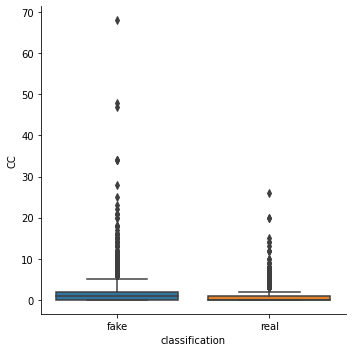

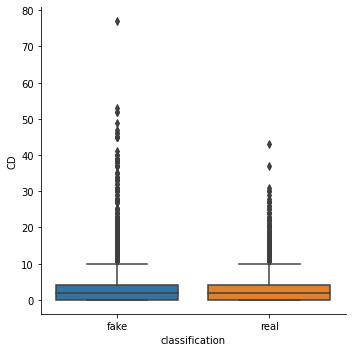

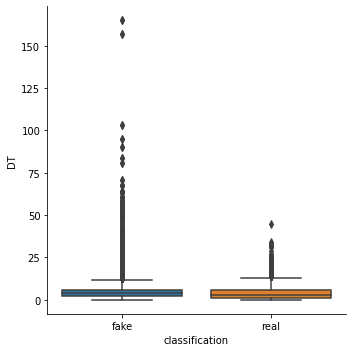

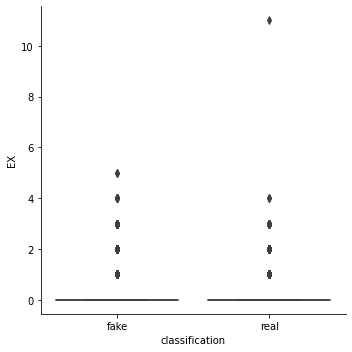

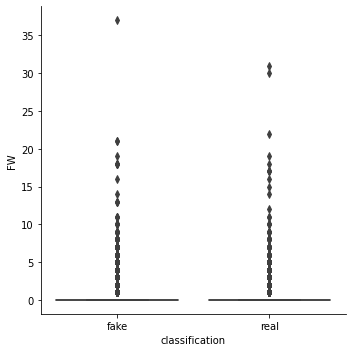

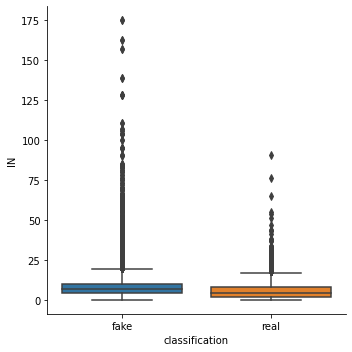

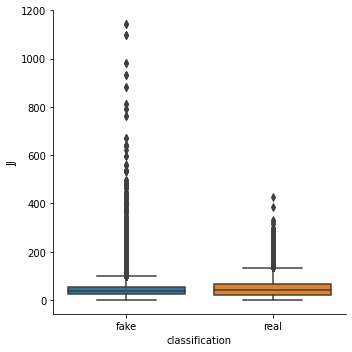

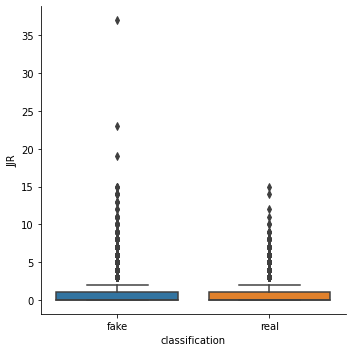

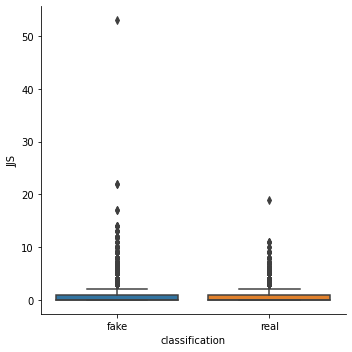

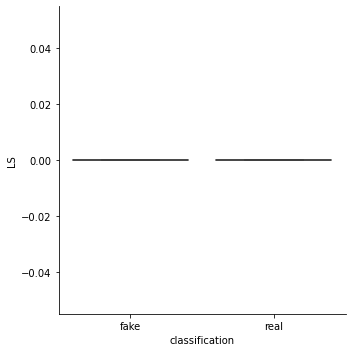

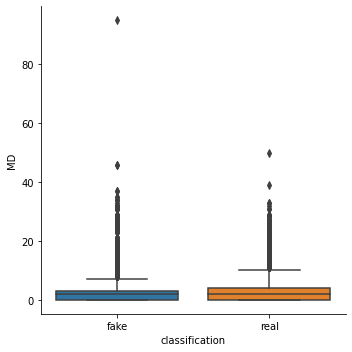

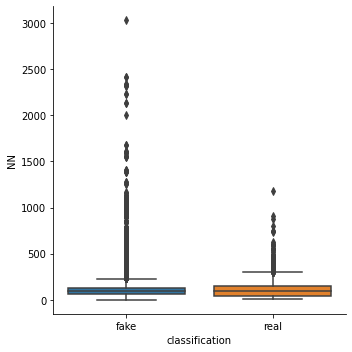

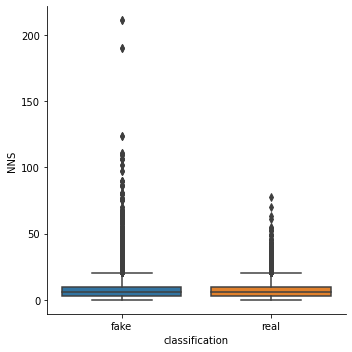

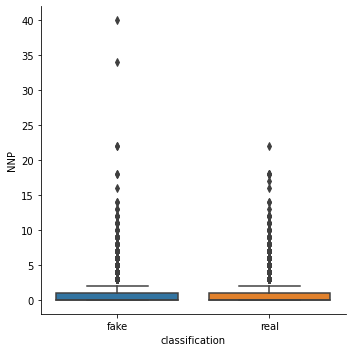

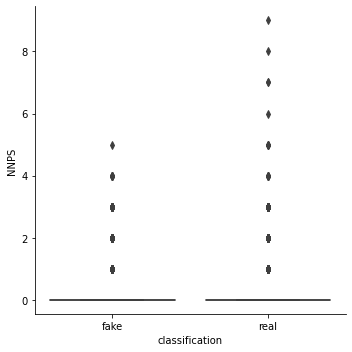

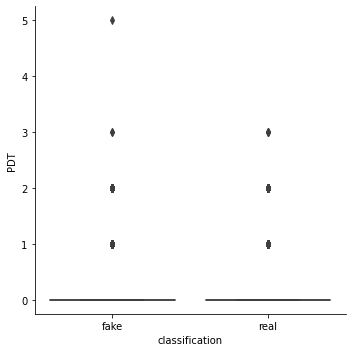

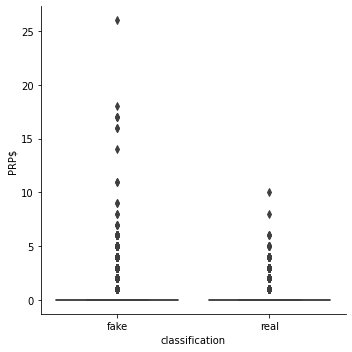

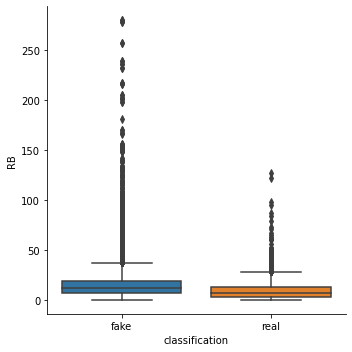

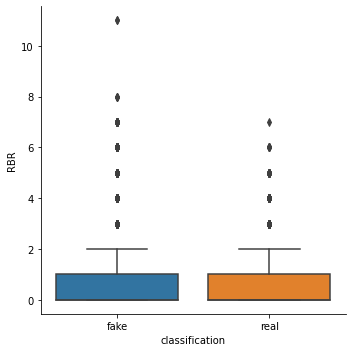

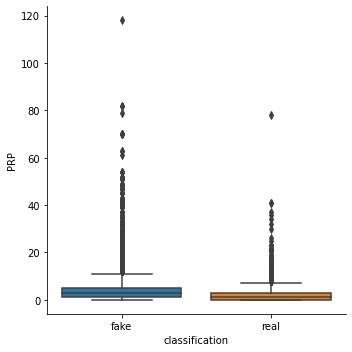

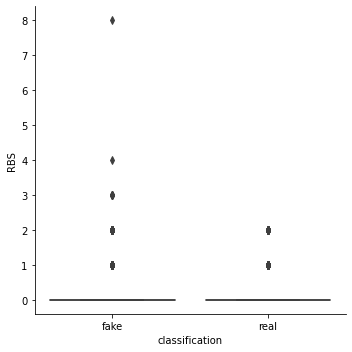

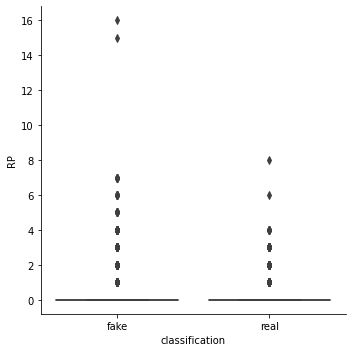

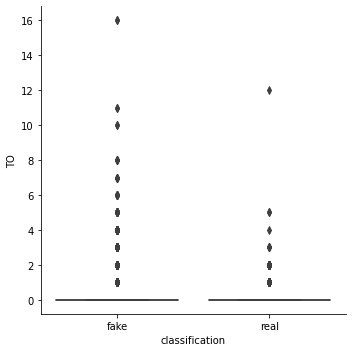

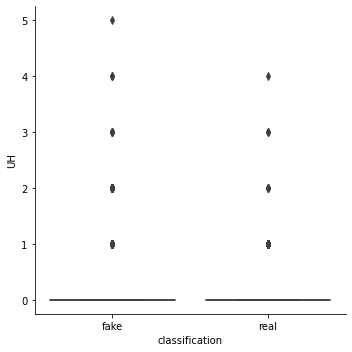

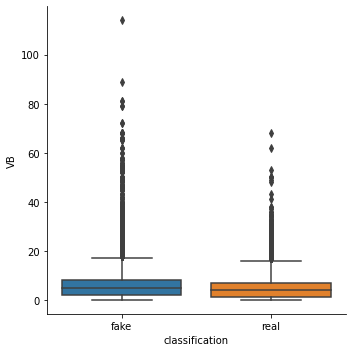

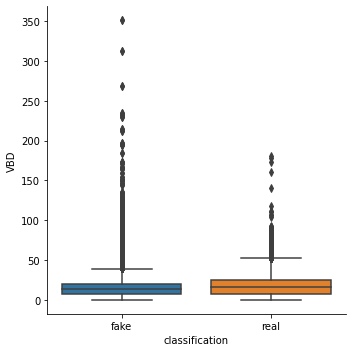

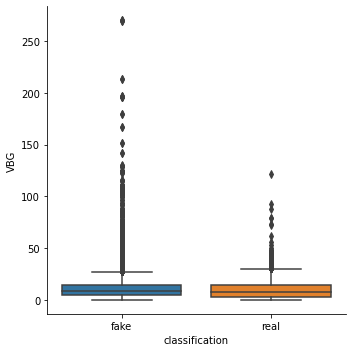

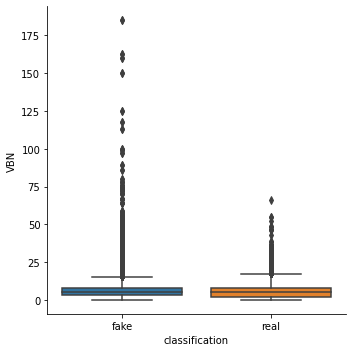

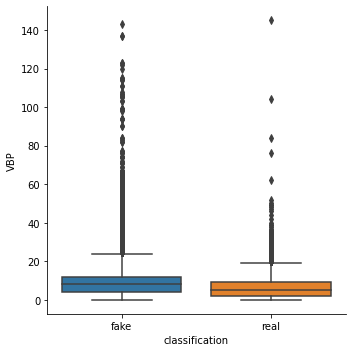

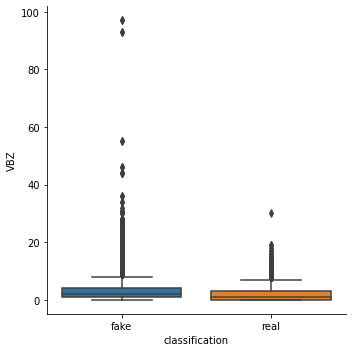

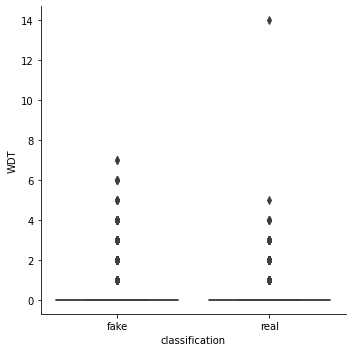

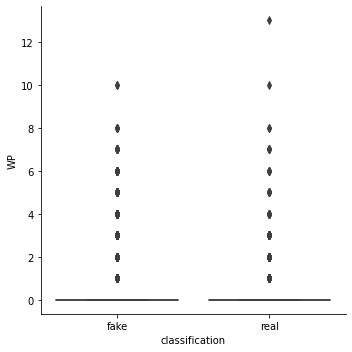

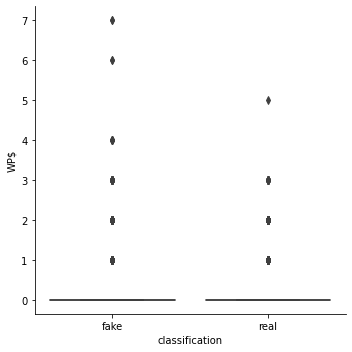

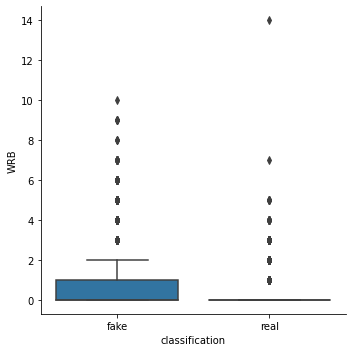

In [66]:
merged_cb_df.tail()
for p in parts_of_speech:
  sns.catplot(x="classification", y=p, kind='box', data=merged_cb_df);

In [67]:
merged_cb_df[merged_cb_df['classification'] == 'real'].describe()

,Unnamed: 0,sentiment,word_count,title_word_count,title_sentiment,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNS,NNP,NNPS,PDT,PRP$,RB,RBR,PRP,RBS,RP,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
count,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.0,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000
mean,33558.500000,0.093633,240.932200,8.344182,-0.069456,0.581388,2.848011,4.086804,0.078493,0.322469,5.404557,47.861599,0.668846,0.747012,0.0,2.860805,108.555893,7.590586,0.557060,0.081808,0.073123,0.198590,8.904230,0.431453,1.801597,0.038242,0.158993,0.037262,0.007097,4.974458,18.268631,9.431827,5.809815,6.480809,1.763681,0.097544,0.076578,0.094042,0.103941
std,6182.411018,0.824232,169.730471,1.486652,0.375668,1.068954,3.181521,3.529242,0.305835,0.908081,4.992878,35.021558,1.109159,1.134053,0.0,3.433420,75.854794,6.129105,1.122734,0.366000,0.272096,0.513575,7.931338,0.748112,2.309023,0.198015,0.434429,0.224598,0.094421,5.004042,13.494225,7.728544,4.933621,5.714828,1.870685,0.354368,0.366366,0.327051,0.386235
min,22851.000000,-0.999800,15.000000,3.000000,-0.940300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28204.750000,-0.883300,93.000000,7.000000,-0.340000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,19.000000,0.000000,0.000000,0.0,0.000000,42.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,3.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33558.500000,0.361200,224.000000,8.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,4.000000,42.000000,0.000000,0.000000,0.0,2.000000,100.000000,6.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,16.000000,8.000000,5.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,38912.250000,0.933700,325.000000,9.000000,0.102700,1.000000,4.000000,6.000000,0.000000,0.000000,8.000000,65.000000,1.000000,1.000000,0.0,4.000000,147.000000,10.000000,1.000000,0.000000,0.000000,0.000000,13.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,7.000000,25.000000,14.000000,8.000000,9.000000,3.000000,0.000000,0.000000,0.000000,0.000000
max,44266.000000,0.999900,2709.000000,15.000000,0.940300,26.000000,43.000000,45.000000,11.000000,31.000000,91.000000,427.000000,15.000000,19.000000,0.0,50.000000,1174.000000,78.000000,22.000000,9.000000,3.000000,10.000000,127.000000,7.000000,78.000000,2.000000,8.000000,12.000000,4.000000,68.000000,181.000000,122.000000,66.000000,145.000000,30.000000,14.000000,13.000000,5.000000,14.000000


In [68]:
merged_cb_df[merged_cb_df['classification'] == 'fake'].describe()

,Unnamed: 0,sentiment,word_count,title_word_count,title_sentiment,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNS,NNP,NNPS,PDT,PRP$,RB,RBR,PRP,RBS,RP,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
count,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.0,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000
mean,11425.000000,-0.056116,262.401777,14.606494,-0.176762,1.177366,2.657608,4.845258,0.113824,0.332808,8.206205,47.863945,0.683778,0.783423,0.0,2.365936,113.246948,7.899392,0.445757,0.068575,0.051026,0.353508,14.667411,0.501378,3.550610,0.050676,0.284233,0.178023,0.029802,5.753446,15.713623,11.274036,6.515207,9.302919,2.591703,0.219509,0.301300,0.069187,0.425627
std,6596.659837,0.851237,252.101928,4.369506,0.464804,1.878103,3.593168,5.656587,0.371580,0.950688,8.275810,50.143709,1.204313,1.301996,0.0,3.081149,113.290458,8.306539,1.065831,0.307851,0.232059,0.800557,15.017449,0.884753,4.332768,0.242283,0.630477,0.563041,0.195654,5.766571,15.924859,11.624139,7.470946,8.673250,3.130387,0.531747,0.696806,0.298912,0.820427
min,0.000000,-1.000000,1.000000,1.000000,-0.975000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5712.500000,-0.957800,155.000000,12.000000,-0.571900,0.000000,0.000000,2.000000,0.000000,0.000000,4.000000,26.000000,0.000000,0.000000,0.0,0.000000,66.000000,3.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,7.000000,5.000000,3.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,11425.000000,-0.194500,220.000000,14.000000,-0.202300,1.000000,2.000000,4.000000,0.000000,0.000000,7.000000,39.000000,0.000000,0.000000,0.0,2.000000,94.000000,6.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,5.000000,13.000000,9.000000,5.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,17137.500000,0.915300,306.000000,17.000000,0.102700,2.000000,4.000000,6.000000,0.000000,0.000000,10.000000,55.000000,1.000000,1.000000,0.0,3.000000,132.000000,10.000000,1.000000,0.000000,0.000000,0.000000,19.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,8.000000,20.000000,14.000000,8.000000,12.000000,4.000000,0.000000,0.000000,0.000000,1.000000
max,22850.000000,1.000000,5193.000000,43.000000,0.970500,68.000000,77.000000,165.000000,5.000000,37.000000,175.000000,1145.000000,37.000000,53.000000,0.0,95.000000,3028.000000,211.000000,40.000000,5.000000,5.000000,26.000000,280.000000,11.000000,118.000000,8.000000,16.000000,16.000000,5.000000,114.000000,351.000000,270.000000,185.000000,143.000000,97.000000,7.000000,10.000000,7.000000,10.000000


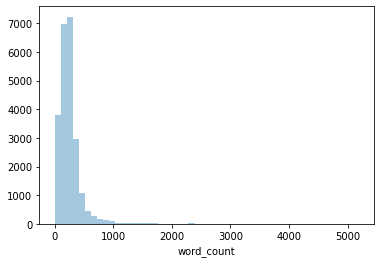

In [69]:
sns.distplot(fake_cb_df['word_count'],  kde=False);

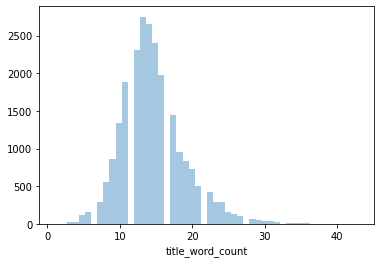

In [70]:
sns.distplot(fake_cb_df['title_word_count'],  kde=False);

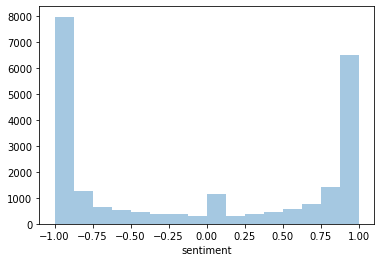

In [71]:
sns.distplot(fake_cb_df['sentiment'],  kde=False);

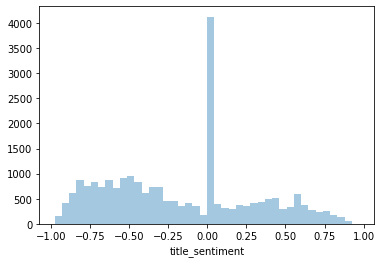

In [72]:
sns.distplot(fake_cb_df['title_sentiment'],  kde=False);

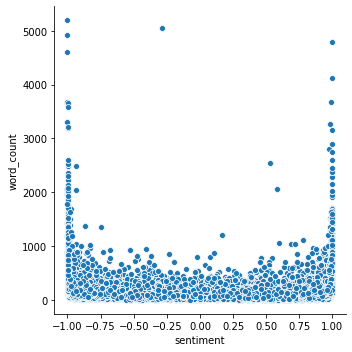

In [73]:
sns.relplot(x="sentiment", y="word_count",data=fake_cb_df);

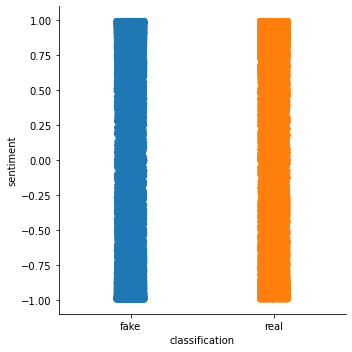

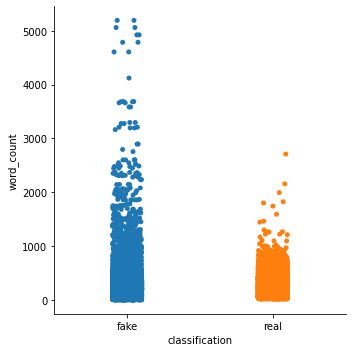

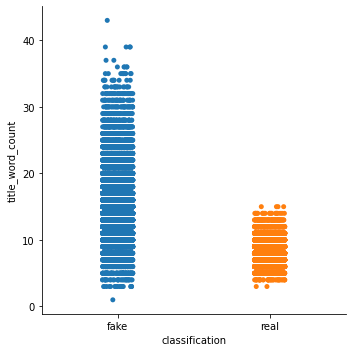

In [74]:
sns.catplot(x="classification", y="sentiment", data=merged_cb_df);
sns.catplot(x="classification", y="word_count", data=merged_cb_df);
sns.catplot(x="classification", y="title_word_count", data=merged_cb_df);

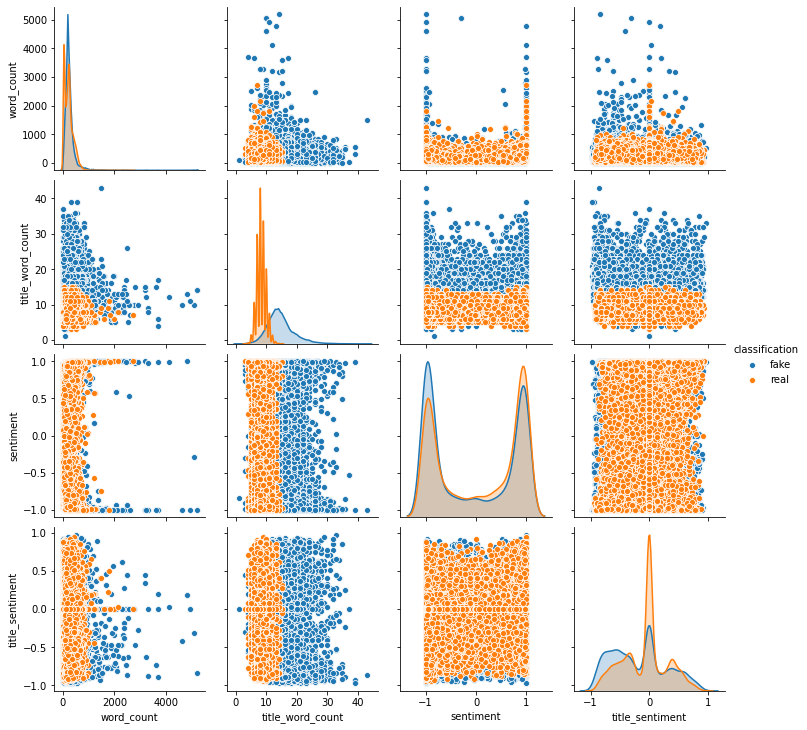

In [75]:
sns.pairplot(merged_cb_df[['word_count', 'title_word_count', 'sentiment', 'title_sentiment', 'classification']], hue="classification");

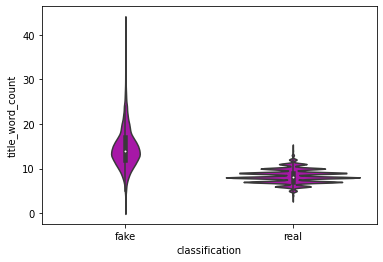

In [76]:
sns.violinplot(x="classification", y="title_word_count", data=merged_cb_df, kind="kde", color="m")

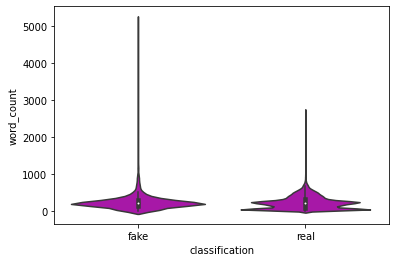

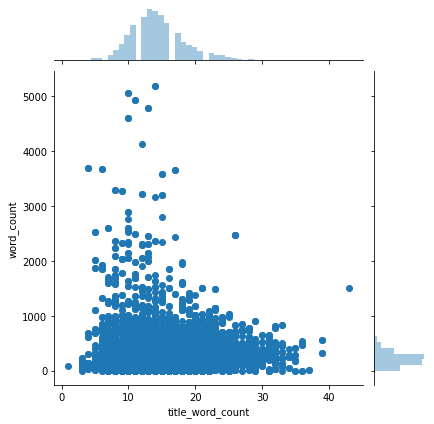

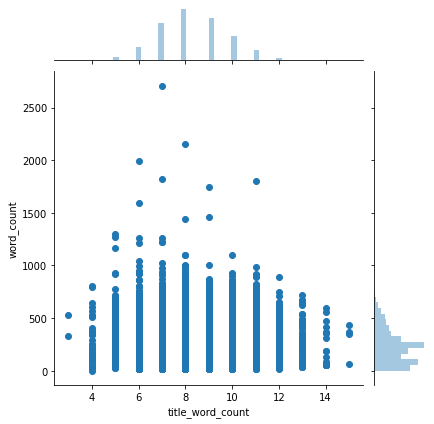

In [77]:
sns.violinplot(x="classification", y="word_count", data=merged_cb_df, kind="kde", color="m")
sns.jointplot(x="title_word_count", y="word_count", data=fake_cb_df[['word_count', 'title_word_count']])
sns.jointplot(x="title_word_count", y="word_count", data=real_cb_df[['word_count', 'title_word_count']])

POS tag list:

CC: coordinating conjunction conjunction  ------  CD: cardinal digit

DT: determiner ------------------------------------------------- EX: existential there 

FW: foreign word --------------------------------------------- IN: preposition/subordinating conjunction

JJ: adjective 'big' --------------------------------------------- JJR: adjective, comparative 'bigger'

JJS: adjective, superlative 'biggest' ----------------- LS: list marker 1)

MD: modal could, will ---------------------------------------  NN: noun, singular 'desk'

NNS: noun plural 'desks' ----------------------------------  NNP: proper noun, singular 'Harrison'

NNPS: proper noun, plural 'Americans' ------------ PDT: predeterminer 'all the kids'

POS: possessive ending parent's -------------------- PRP: personal pronoun I, he, she

PRP$: possessive pronoun my, his, hers --------- RB: adverb very, silently,

RBR: adverb, comparative better --------------------- RBS: adverb, superlative best

RP: particle give up ------------------------------------------ TO: to go 'to' the store.

UH: interjection errrm --------------------------------------  VB: verb, base form take

VBD: verb, past tense took ------------------------------ VBG: verb, gerund/present participle taking

VBN: verb, past participle taken  ---------------------- VBP: verb, sing. present, non-3d take

VBZ: verb, 3rd person sing. present takes -------  WDT: wh-determiner which

WP: wh-pronoun who, what  -----------------------------  WP$: possessive wh-pronoun whose

WRB: wh-abverb where, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


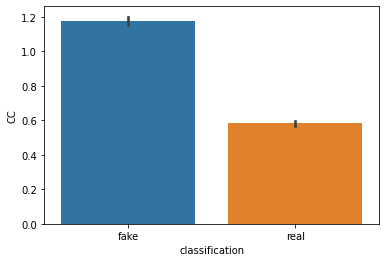

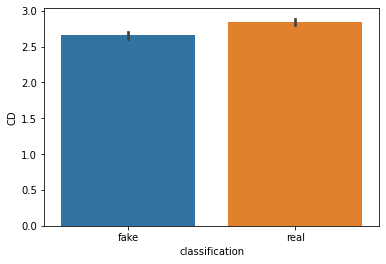

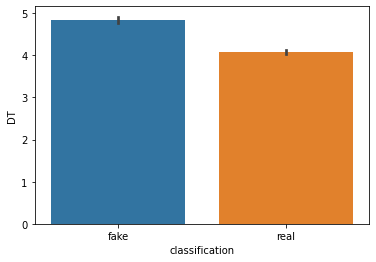

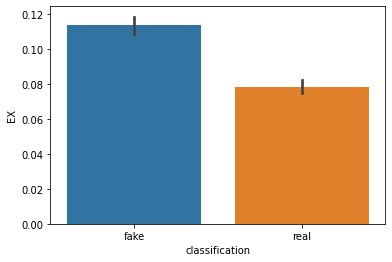

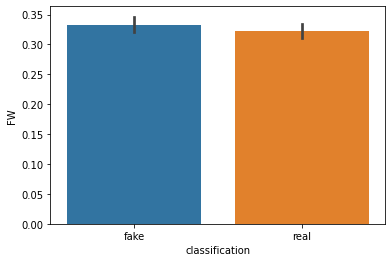

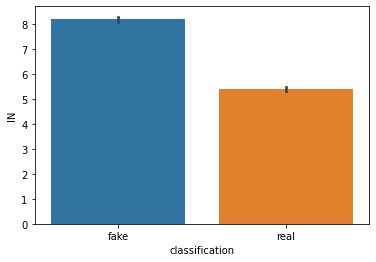

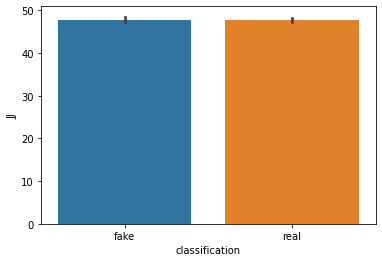

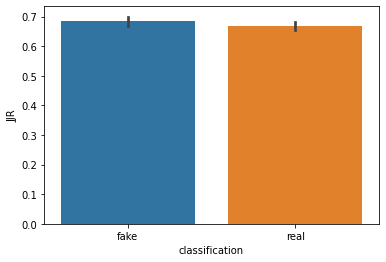

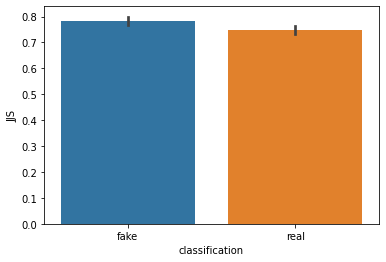

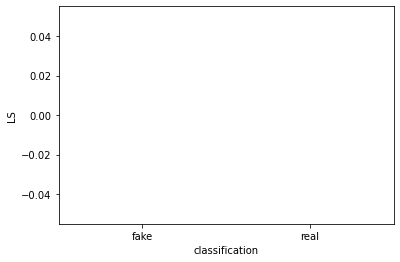

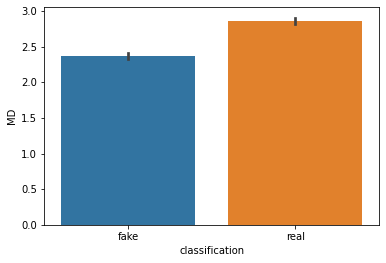

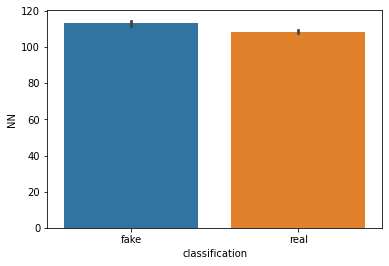

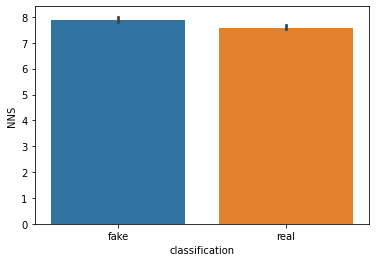

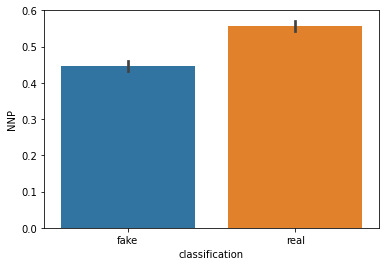

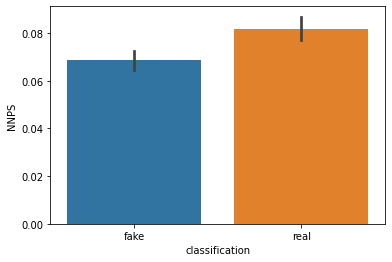

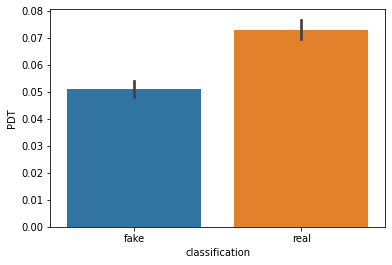

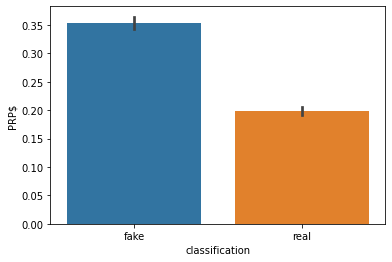

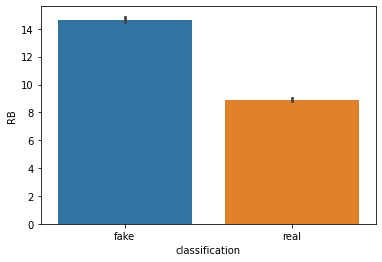

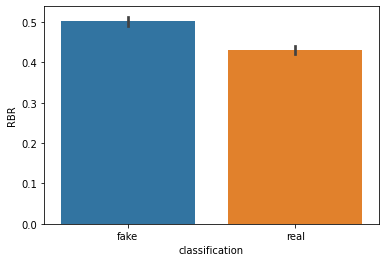

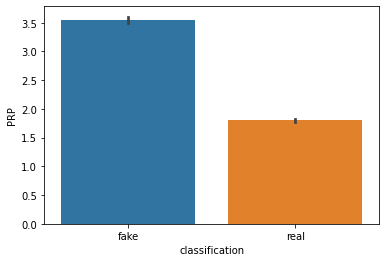

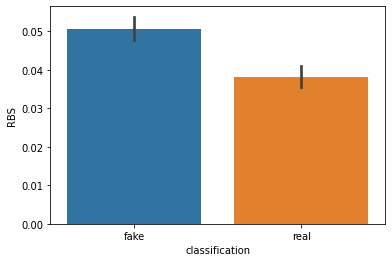

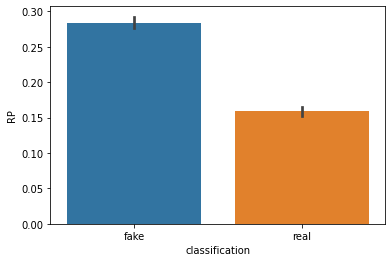

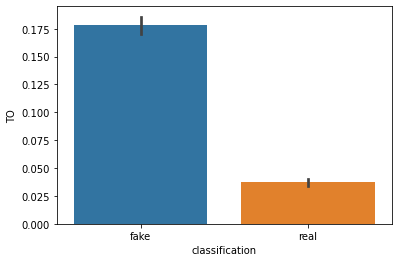

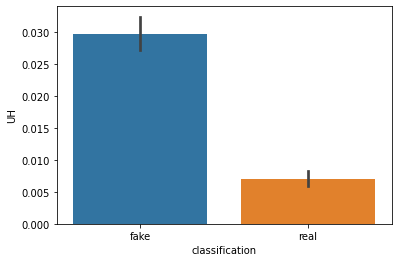

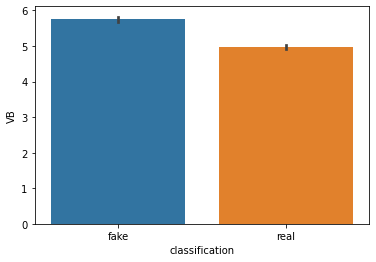

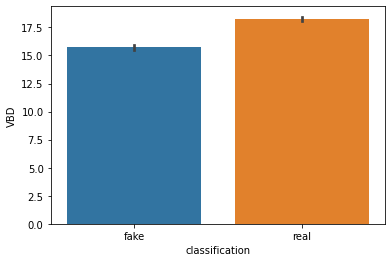

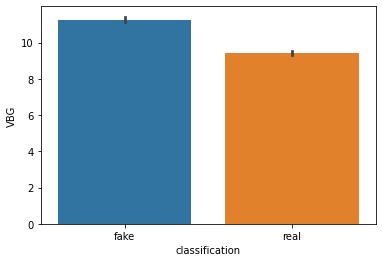

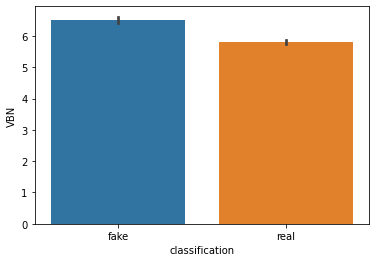

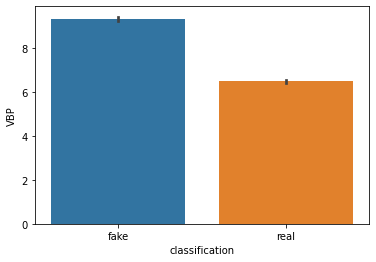

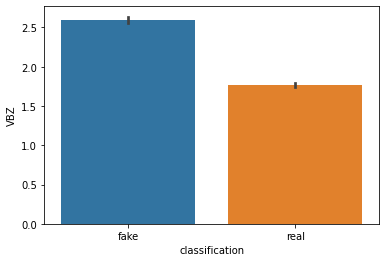

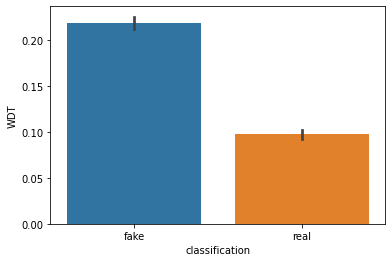

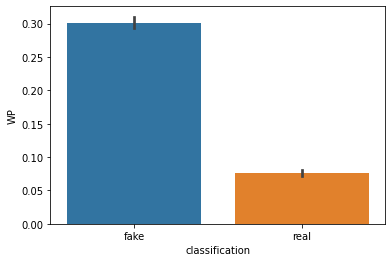

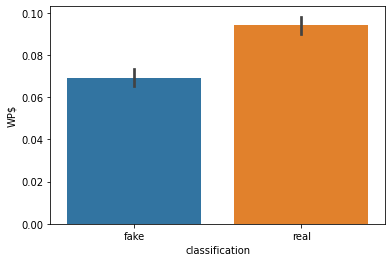

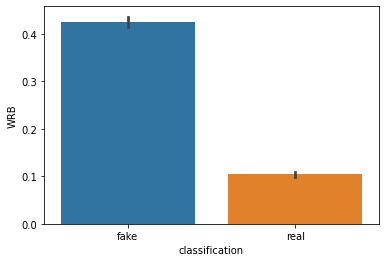

In [78]:
#This plot visualizes the differences in the usage of different parts of speech
#between real and fake news articles
for pos in parts_of_speech:
  plt.figure()
  sns.barplot(data = merged_cb_df, x = 'classification' , y=pos);

In [0]:
#Adjective to noun ratios
#NN, NNP, NNPS, NNS  : JJ, JJR, JJS
test_df = merged_cb_df

testlist = list(test_df)
test_df['noun_sum'] = test_df[['NN', 'NNP', 'NNPS', 'NNS']].sum(axis=1)
test_df.head()
test_df['adj_sum'] = test_df[['JJ', 'JJR', 'JJS']].sum(axis=1)




In [82]:
#test_df['n_to_a_r'] = test_df[['noun_sum']].apply(lambda x: divide(test_df[['noun_sum','adj_sum']]) , axis = 1)
test_df['n_to_a_r'] = 0.0

with tqdm_notebook(total=test_df.shape[0]) as pbar:
  for index, row in test_df.iterrows():     
    test_df['n_to_a_r'][index] = test_df['noun_sum'][index] / test_df['adj_sum'][index]
    pbar.update(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [0]:
#just chose 33 as an arbitrarily large number
#this code is to prevent calculation of the mean due to np.inf
test_df = test_df.replace([np.inf, -np.inf], 33)
#test_df = test_df[test_df['n_to_a_r'] == ]

In [87]:
test_df[test_df['classification']== 'fake'].describe()


,Unnamed: 0,sentiment,word_count,title_word_count,title_sentiment,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNS,NNP,NNPS,PDT,PRP$,RB,RBR,PRP,RBS,RP,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,noun_sum,adj_sum,n_to_a_r
count,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.0,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22851.000000,22843.000000
mean,11425.000000,-0.056116,262.401777,14.606494,-0.176762,1.177366,2.657608,4.845258,0.113824,0.332808,8.206205,47.863945,0.683778,0.783423,0.0,2.365936,113.246948,7.899392,0.445757,0.068575,0.051026,0.353508,14.667411,0.501378,3.550610,0.050676,0.284233,0.178023,0.029802,5.753446,15.713623,11.274036,6.515207,9.302919,2.591703,0.219509,0.301300,0.069187,0.425627,121.660671,49.331145,2.707751
std,6596.659837,0.851237,252.101928,4.369506,0.464804,1.878103,3.593168,5.656587,0.371580,0.950688,8.275810,50.143709,1.204313,1.301996,0.0,3.081149,113.290458,8.306539,1.065831,0.307851,0.232059,0.800557,15.017449,0.884753,4.332768,0.242283,0.630477,0.563041,0.195654,5.766571,15.924859,11.624139,7.470946,8.673250,3.130387,0.531747,0.696806,0.298912,0.820427,120.571153,51.487459,1.186058
min,0.000000,-1.000000,1.000000,1.000000,-0.975000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5712.500000,-0.957800,155.000000,12.000000,-0.571900,0.000000,0.000000,2.000000,0.000000,0.000000,4.000000,26.000000,0.000000,0.000000,0.0,0.000000,66.000000,3.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,7.000000,5.000000,3.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,71.000000,27.000000,2.156863
50%,11425.000000,-0.194500,220.000000,14.000000,-0.202300,1.000000,2.000000,4.000000,0.000000,0.000000,7.000000,39.000000,0.000000,0.000000,0.0,2.000000,94.000000,6.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,5.000000,13.000000,9.000000,5.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,101.000000,40.000000,2.500000
75%,17137.500000,0.915300,306.000000,17.000000,0.102700,2.000000,4.000000,6.000000,0.000000,0.000000,10.000000,55.000000,1.000000,1.000000,0.0,3.000000,132.000000,10.000000,1.000000,0.000000,0.000000,0.000000,19.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,8.000000,20.000000,14.000000,8.000000,12.000000,4.000000,0.000000,0.000000,0.000000,1.000000,142.000000,57.000000,2.944444
max,22850.000000,1.000000,5193.000000,43.000000,0.970500,68.000000,77.000000,165.000000,5.000000,37.000000,175.000000,1145.000000,37.000000,53.000000,0.0,95.000000,3028.000000,211.000000,40.000000,5.000000,5.000000,26.000000,280.000000,11.000000,118.000000,8.000000,16.000000,16.000000,5.000000,114.000000,351.000000,270.000000,185.000000,143.000000,97.000000,7.000000,10.000000,7.000000,10.000000,3103.000000,1162.000000,33.000000


In [88]:
test_df[test_df['classification']== 'real'].describe()

,Unnamed: 0,sentiment,word_count,title_word_count,title_sentiment,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,LS,MD,NN,NNS,NNP,NNPS,PDT,PRP$,RB,RBR,PRP,RBS,RP,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,noun_sum,adj_sum,n_to_a_r
count,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.0,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000,21416.000000
mean,33558.500000,0.093633,240.932200,8.344182,-0.069456,0.581388,2.848011,4.086804,0.078493,0.322469,5.404557,47.861599,0.668846,0.747012,0.0,2.860805,108.555893,7.590586,0.557060,0.081808,0.073123,0.198590,8.904230,0.431453,1.801597,0.038242,0.158993,0.037262,0.007097,4.974458,18.268631,9.431827,5.809815,6.480809,1.763681,0.097544,0.076578,0.094042,0.103941,116.785347,49.277456,2.513695
std,6182.411018,0.824232,169.730471,1.486652,0.375668,1.068954,3.181521,3.529242,0.305835,0.908081,4.992878,35.021558,1.109159,1.134053,0.0,3.433420,75.854794,6.129105,1.122734,0.366000,0.272096,0.513575,7.931338,0.748112,2.309023,0.198015,0.434429,0.224598,0.094421,5.004042,13.494225,7.728544,4.933621,5.714828,1.870685,0.354368,0.366366,0.327051,0.386235,81.064712,36.044490,0.736746
min,22851.000000,-0.999800,15.000000,3.000000,-0.940300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.900000
25%,28204.750000,-0.883300,93.000000,7.000000,-0.340000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,19.000000,0.000000,0.000000,0.0,0.000000,42.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,3.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,20.000000,2.071429
50%,33558.500000,0.361200,224.000000,8.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000,4.000000,42.000000,0.000000,0.000000,0.0,2.000000,100.000000,6.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,16.000000,8.000000,5.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,108.000000,43.000000,2.400000
75%,38912.250000,0.933700,325.000000,9.000000,0.102700,1.000000,4.000000,6.000000,0.000000,0.000000,8.000000,65.000000,1.000000,1.000000,0.0,4.000000,147.000000,10.000000,1.000000,0.000000,0.000000,0.000000,13.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,7.000000,25.000000,14.000000,8.000000,9.000000,3.000000,0.000000,0.000000,0.000000,0.000000,158.000000,67.000000,2.813559
max,44266.000000,0.999900,2709.000000,15.000000,0.940300,26.000000,43.000000,45.000000,11.000000,31.000000,91.000000,427.000000,15.000000,19.000000,0.0,50.000000,1174.000000,78.000000,22.000000,9.000000,3.000000,10.000000,127.000000,7.000000,78.000000,2.000000,8.000000,12.000000,4.000000,68.000000,181.000000,122.000000,66.000000,145.000000,30.000000,14.000000,13.000000,5.000000,14.000000,1245.000000,439.000000,16.000000


Though this did not yeild much information, an interesting note is that the standard deviation of the noun to adjective ration of the real news set is far lower than that of the fake set.  
The real set also doesnt have any 0 valued ratios

It may be interesting to view these curves since we have the data.
It can be assumed that it follows a normal distribution

In [0]:
from scipy.stats import norm

In [0]:
fake_mu = 2.7078
fake_sigma = 1.1861
fake_lower = 0
fake_upper = 33

real_mu = 2.5137
real_sigma = 0.7367
real_lower = 0.9
real_upper = 16

fake_x = np.linspace(-1, 16, 500)
real_x =  np.linspace(-1,16, 500)

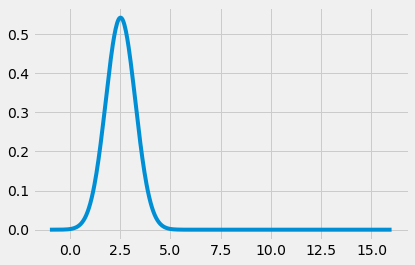

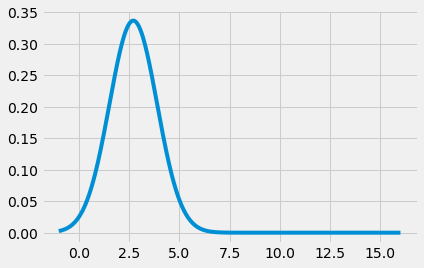

In [111]:
#look at curves
plt.plot(real_x, stats.norm.pdf(real_x, real_mu, real_sigma))
plt.show()
plt.figure()
print("\n")
plt.plot(fake_x, stats.norm.pdf(fake_x, fake_mu, fake_sigma))
plt.show()

The fake dataset has a wider curve.  the difference is slight but when used in a model, may be capable of classifying some outlyers.  